# Silver Box System

Note: The example shown in this notebook is taken from the companion book [Nonlinear System Identification and Forecasting: Theory and Practice with SysIdentPy](https://sysidentpy.org/book/0-Preface/).

The description content mainly derives (copy and paste) from the [associated paper - Three free data sets for development and benchmarking in nonlinear system identification](https://ieeexplore.ieee.org/document/6669201). For a detailed description, readers are referred to the linked reference.

> The Silverbox system can be seen as an electronic implementation of the Duffing oscillator. It is build as a 2nd order linear time-invariant system with a 3rd degree polynomial static nonlinearity around it in feedback. This type of dynamics are, for instance, often encountered in mechanical systems [Nonlinear Benchmark - Silverbox](https://www.nonlinearbenchmark.org/benchmarks/silverbox).

In this case study, we will create a NARX model for the Silver box benchmark. The Silver box represents a simplified version of mechanical oscillating processes, which are a critical category of nonlinear dynamic systems. Examples include vehicle suspensions, where shock absorbers and progressive springs play vital roles. The data generated by the Silver box provides a simplified representation of such combined components. The electrical circuit generating this data closely approximates, but does not perfectly match, the idealized models described below.

As described in the original paper, the system was excited using a general waveform generator (HPE1445A). The input signal begins as a discrete-time signal $r(k)$, which is converted to an analog signal $r_c(t)$ using zero-order-hold reconstruction. The actual excitation signal $u_0(t)$ is then obtained by passing $r_c(t)$ through an analog low-pass filter $G(p)$ to eliminate high-frequency content around multiples of the sampling frequency. Here, $p$ denotes the differentiation operator. Thus, the input is given by:

$$
u_0(t) = G(p) r_c(t).
$$

The input and output signals were measured using HP1430A data acquisition cards, with synchronized clocks for the acquisition and generator cards. The sampling frequency was:

$$
f_s = \frac{10^7}{2^{14}} = 610.35 \, \text{Hz}.
$$

The silver box uses analog electrical circuitry to generate data representing a nonlinear mechanical resonating system with a moving mass $m$, viscous damping $d$, and a nonlinear spring $k(y)$. The electrical circuit is designed to relate the displacement $y(t)$ (the output) to the force $u(t)$ (the input) by the following differential equation:

$$
m \frac{d^2 y(t)}{dt^2} + d \frac{d y(t)}{dt} + k(y(t)) y(t) = u(t).
$$

The nonlinear progressive spring is described by a static, position-dependent stiffness:

$$
k(y(t)) = a + b y^2(t).
$$

The signal-to-noise ratio is sufficiently high to model the system without accounting for measurement noise. However, measurement noise can be included by replacing $y(t)$ with the artificial variable $x(t)$ in the equation above, and introducing disturbances $w(t)$ and $e(t)$ as follows:

$$
\begin{align}
& m \frac{d^2 x(t)}{dt^2} + d \frac{d x(t)}{dt} + k(x(t)) x(t) = u(t) + w(t), \\
& k(x(t)) = a + b x^2(t), \\
& y(t) = x(t) + e(t).
\end{align}
$$

### Required Packages and Versions

To ensure that you can replicate this case study, it is essential to use specific versions of the required packages. Below is a list of the packages along with their respective versions needed for running the case studies effectively.

To install all the required packages, you can create a `requirements.txt` file with the following content:

```
sysidentpy==0.4.0
pandas==2.2.2
numpy==1.26.0
matplotlib==3.8.4
nonlinear_benchmarks==0.1.2
```

Then, install the packages using:

```
pip install -r requirements.txt
```

- Ensure that you use a virtual environment to avoid conflicts between package versions.
- Versions specified are based on compatibility with the code examples provided. If you are using different versions, some adjustments in the code might be necessary.

### SysIdentPy configuration

In this section, we will demonstrate the application of SysIdentPy to the Silver box dataset.  The following code will guide you through the process of loading the dataset, configuring the SysIdentPy parameters, and building a model for mentioned system.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function import Polynomial, Fourier
from sysidentpy.parameter_estimation import LeastSquares
from sysidentpy.metrics import root_mean_squared_error
from sysidentpy.utils.plotting import plot_results

import nonlinear_benchmarks

train_val, test = nonlinear_benchmarks.Silverbox(atleast_2d=True)

x_train, y_train = train_val.u, train_val.y
test_multisine, test_arrow_full, test_arrow_no_extrapolation = test
x_test, y_test = test_multisine.u, test_multisine.y

n = test_multisine.state_initialization_window_length

We used the `nonlinear_benchmarks` package to load the data. The user is referred to the [package documentation - GerbenBeintema/nonlinear_benchmarks: The official dataload for http://www.nonlinearbenchmark.org/ (github.com)](https://github.com/GerbenBeintema/nonlinear_benchmarks/tree/master) to check the details of how to use it.

The following plot detail the training and testing data of the experiment.

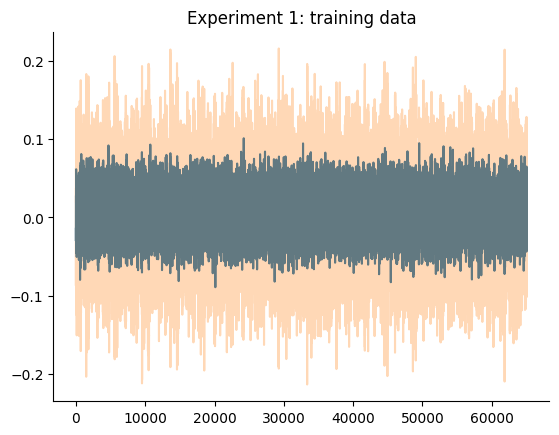

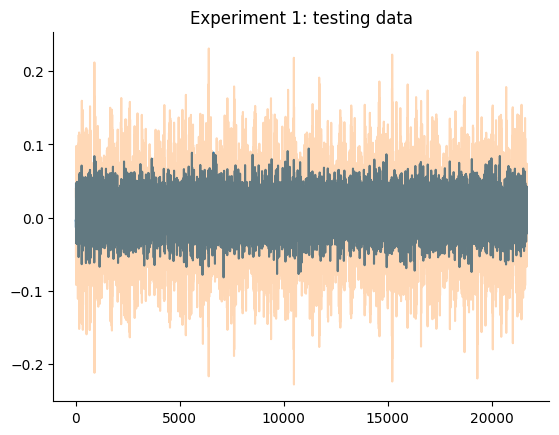

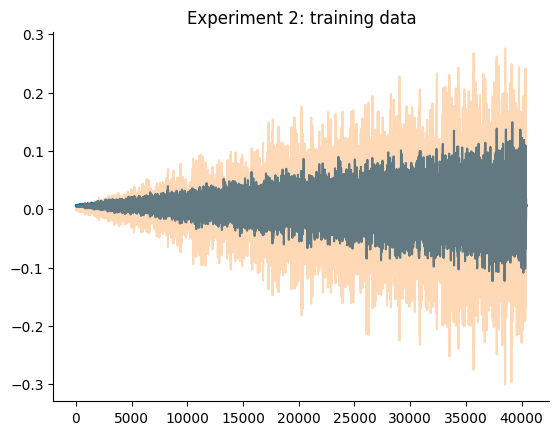

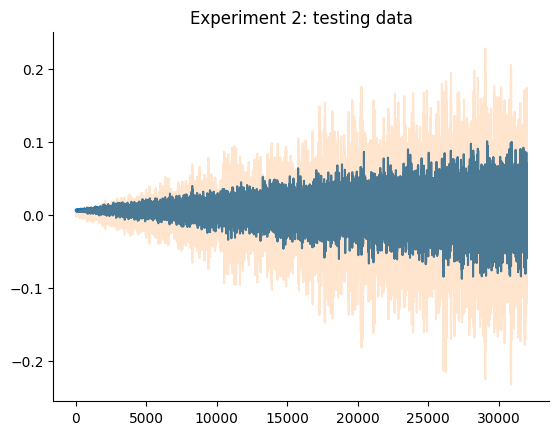

In [3]:
plt.plot(x_train)
plt.plot(y_train, alpha=0.3)
plt.title("Experiment 1: training data")
plt.show()

plt.plot(x_test)
plt.plot(y_test, alpha=0.3)
plt.title("Experiment 1: testing data")
plt.show()

plt.plot(test_arrow_full.u)
plt.plot(test_arrow_full.y, alpha=0.3)
plt.title("Experiment 2: training data")
plt.show()

plt.plot(test_arrow_no_extrapolation.u)
plt.plot(test_arrow_no_extrapolation.y, alpha=0.2)
plt.title("Experiment 2: testing data")
plt.show()

> Important Note

The goal of this benchmark is to develop a model that outperforms the state-of-the-art (SOTA) model presented in the benchmarking paper. However, the results in the [paper](https://arxiv.org/pdf/2012.07697) differ from those provided in the  [GitHub repository](https://github.com/GerbenBeintema/SS-encoder-WH-Silver/blob/main/SS%20encoder%20Silverbox.ipynb).

| nx  | Set             | NRMS    | RMS (mV)   |
| --- | --------------- | ------- | ---------- |
| 2   | Train           | 0.10653 | 5.8103295  |
| 2   | Validation      | 0.11411 | 6.1938068  |
| 2   | Test            | 0.19151 | 10.2358533 |
| 2   | Test (no extra) | 0.12284 | 5.2789727  |
| 4   | Train           | 0.03571 | 1.9478290  |
| 4   | Validation      | 0.03922 | 2.1286373  |
| 4   | Test            | 0.12712 | 6.7943448  |
| 4   | Test (no extra) | 0.05204 | 2.2365904  |
| 8   | Train           | 0.03430 | 1.8707026  |
| 8   | Validation      | 0.03732 | 2.0254112  |
| 8   | Test            | 0.10826 | 5.7865255  |
| 8   | Test (no extra) | 0.04743 | 2.0382715  |
> Table: results presented in the github.

It appears that the values shown in the paper actually represent the training time, not the error metrics. I will contact the authors to confirm this information. According to the Nonlinear Benchmark website, the information is as follows:

![](https://github.com/wilsonrljr/sysidentpy-data/blob/4085901293ba5ed5674bb2911ef4d1fa20f3438d/book/assets/silver_sota.png?raw=true)

where the values in the "Training time" column matches the ones presented as error metrics in the paper.

> While we await confirmation of the correct values for this benchmark, we will demonstrate the performance of SysIdentPy. However, we will refrain from making any comparisons or attempting to improve the model at this stage.

### Results

We will start (as we did in every other case study) with a basic configuration of FROLS using a polynomial basis function with degree equal 2. The `xlag` and `ylag` are set to $7$ in this first example. Because the dataset is considerably large, we will start with `n_info_values=40`. Because we dealing with a large training dataset, we will use the `err_tol` instead of information criteria to have a faster performance. We will also set `n_terms=40`, which means that the search will stop if the `err_tol` is reached or 40 regressors is tested in the `ERR` algorithm. While this approach might result in a sub-optimal model, it is a reasonable starting point for our first attempt. There are three different experiments: multisine, arrow (full), and arrow (no extrapolation).

0.1423804033714937 7.727682109791501


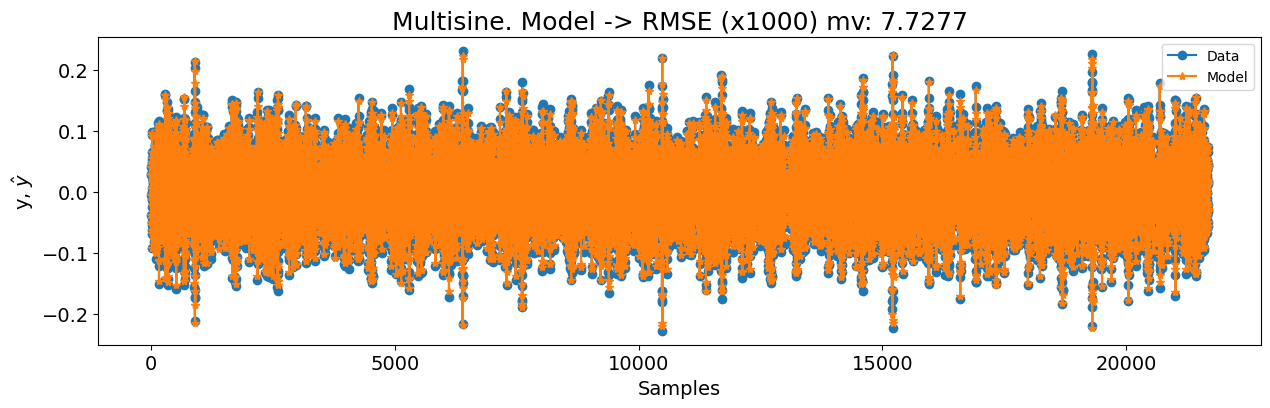

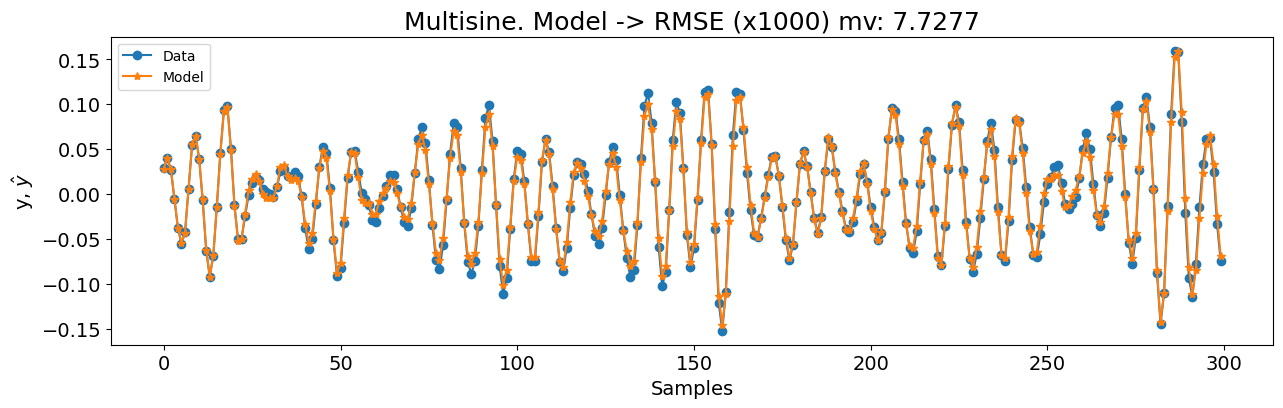

In [4]:
basis_function = Polynomial(degree=2)
model = FROLS(
    xlag=7,
    ylag=7,
    basis_function=basis_function,
    estimator=LeastSquares(),
    err_tol=0.999,
    n_terms=40,
    order_selection=False,
)

model.fit(X=x_train, y=y_train)
y_test = np.concatenate([y_train[-model.max_lag :], y_test])
x_test = np.concatenate([x_train[-model.max_lag :], x_test])
yhat = model.predict(X=x_test, y=y_test[: model.max_lag, :])
rmse = root_mean_squared_error(y_test[model.max_lag + n :], yhat[model.max_lag + n :])
nrmse = rmse / y_test.std()
rmse_mv = 1000 * rmse
print(nrmse, rmse_mv)
plot_results(
    y=y_test[model.max_lag :],
    yhat=yhat[model.max_lag :],
    n=30000,
    figsize=(15, 4),
    title=f"Multisine. Model -> RMSE (x1000) mv: {round(rmse_mv, 4)}",
)

plot_results(
    y=y_test[model.max_lag :],
    yhat=yhat[model.max_lag :],
    n=300,
    figsize=(15, 4),
    title=f"Multisine. Model -> RMSE (x1000) mv: {round(rmse_mv, 4)}",
)

0.07762658947015803 4.14903534238172


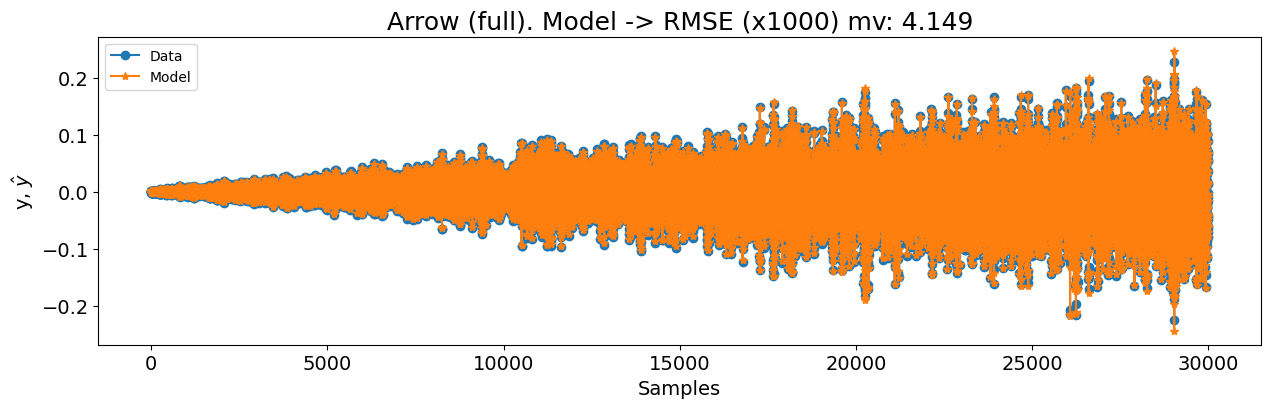

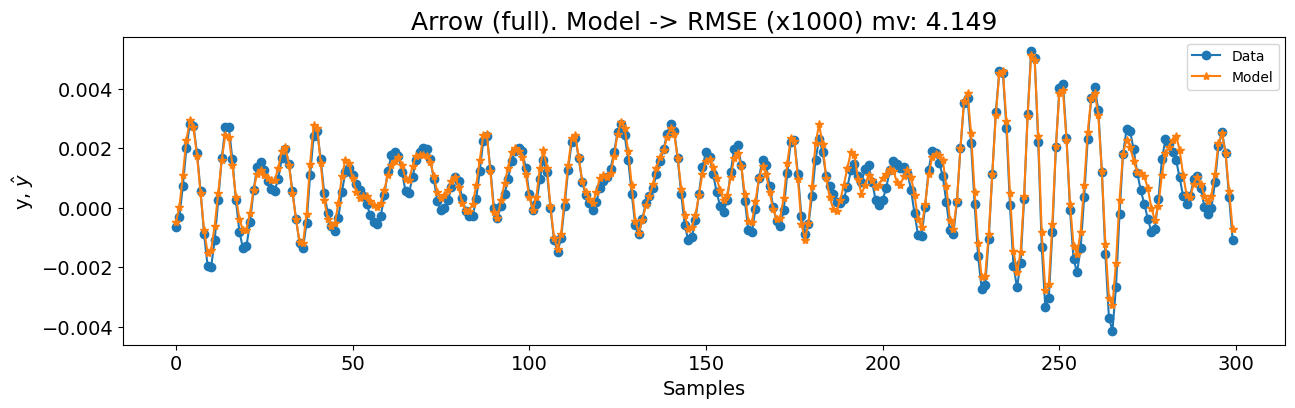

In [5]:
x_train, y_train = train_val.u, train_val.y
test_multisine, test_arrow_full, test_arrow_no_extrapolation = test
x_test, y_test = test_arrow_full.u, test_arrow_full.y

n = test_arrow_full.state_initialization_window_length

basis_function = Polynomial(degree=3)
model = FROLS(
    xlag=14,
    ylag=14,
    basis_function=basis_function,
    estimator=LeastSquares(),
    err_tol=0.9999,
    n_terms=80,
    order_selection=False,
)

model.fit(X=x_train, y=y_train)
# we will not concatente the last values from train data to use as initial condition here because
# this test data have a very different behavior.
# However, if you want you can do that and you will see that the model will still perform
# great after a few iterations
yhat = model.predict(X=x_test, y=y_test[: model.max_lag, :])
rmse = root_mean_squared_error(y_test[model.max_lag + n :], yhat[model.max_lag + n :])
nrmse = rmse / y_test.std()
rmse_mv = 1000 * rmse

print(nrmse, rmse_mv)

plot_results(
    y=y_test[model.max_lag :],
    yhat=yhat[model.max_lag :],
    n=30000,
    figsize=(15, 4),
    title=f"Arrow (full). Model -> RMSE (x1000) mv: {round(rmse_mv, 4)}",
)

plot_results(
    y=y_test[model.max_lag :],
    yhat=yhat[model.max_lag :],
    n=300,
    figsize=(15, 4),
    title=f"Arrow (full). Model -> RMSE (x1000) mv: {round(rmse_mv, 4)}",
)

0.05187400789723806 2.2293393254015776


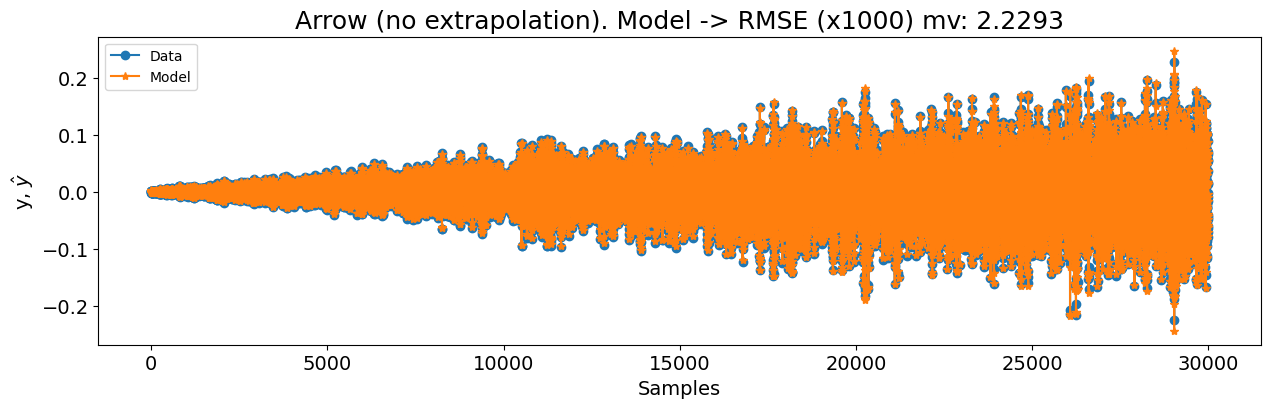

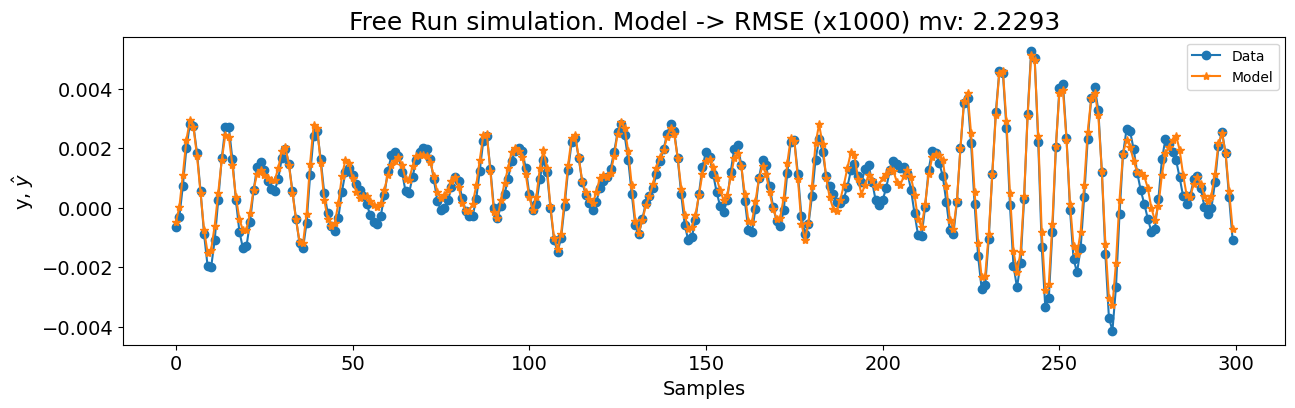

In [6]:
x_train, y_train = train_val.u, train_val.y
test_multisine, test_arrow_full, test_arrow_no_extrapolation = test
x_test, y_test = test_arrow_no_extrapolation.u, test_arrow_no_extrapolation.y

n = test_arrow_no_extrapolation.state_initialization_window_length

basis_function = Polynomial(degree=3)
model = FROLS(
    xlag=14,
    ylag=14,
    basis_function=basis_function,
    estimator=LeastSquares(),
    err_tol=0.9999,
    n_terms=40,
    order_selection=False,
)

model.fit(X=x_train, y=y_train)
yhat = model.predict(X=x_test, y=y_test[: model.max_lag, :])
rmse = root_mean_squared_error(y_test[model.max_lag + n :], yhat[model.max_lag + n :])
nrmse = rmse / y_test.std()
rmse_mv = 1000 * rmse
print(nrmse, rmse_mv)

plot_results(
    y=y_test[model.max_lag :],
    yhat=yhat[model.max_lag :],
    n=30000,
    figsize=(15, 4),
    title=f"Arrow (no extrapolation). Model -> RMSE (x1000) mv: {round(rmse_mv, 4)}",
)

plot_results(
    y=y_test[model.max_lag :],
    yhat=yhat[model.max_lag :],
    n=300,
    figsize=(15, 4),
    title=f"Free Run simulation. Model -> RMSE (x1000) mv: {round(rmse_mv, 4)}",
)